# Sentiment Analysis and Prediction in Python

In [3]:
%%capture
!pip install wordcloud

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load data as a DataFrame
df = pd.read_csv("movie_reviews.csv")

# Data Previewed
df.sample(3)

,text,label
3693,"It's not too bad a b movie, with Sanders, Barr...",1
2435,At least for me. I have been following the car...,0
2449,"I don't know what you guys are talking about, ...",0


## Inspect and explore our data


In [5]:
# Inspect the data types and non-null rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


In [6]:
# Check the value counts of the sentiment label
df["label"].value_counts(normalize=True)

0    0.5085
1    0.4915
Name: label, dtype: float64

Creating a word cloud

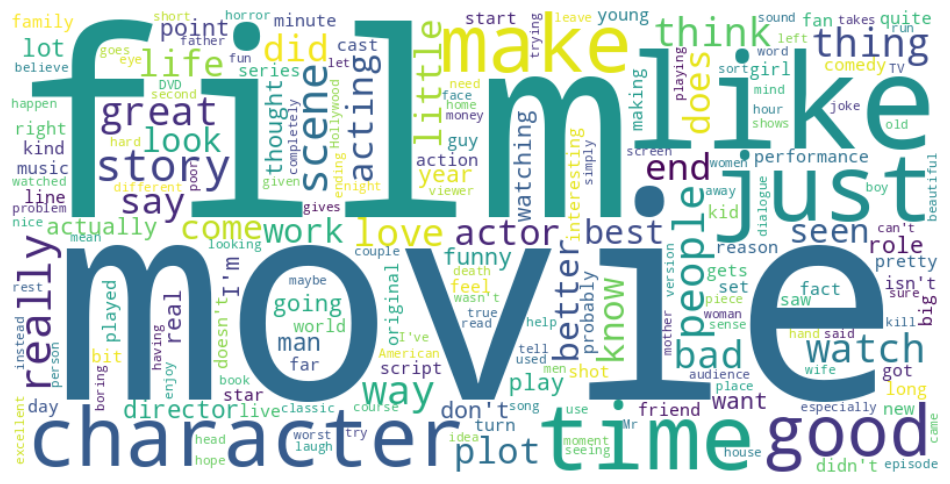

In [7]:
# Concatenate the text review data
reviews = " ".join(df["text"])

# Create the word cloud image, stopwords are irrelavent words(the, and, or)
word_cloud = WordCloud(background_color="white", 
                        stopwords=ENGLISH_STOP_WORDS,
                       width=800,
                       height=400
                      )

# Generate the word cloud using the review data
word_cloud.generate(reviews)

# Display plt.the word cloud
plt.rcParams["figure.figsize"] = (12, 8)
# interpolation for smoothness
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Pre-processing the review text
Using TfIdf to calculate the importance of words

In [8]:
# Specify the word pattern to tokenize
pattern = r"[a-zA-Z]+"

# Vectroizer and fit data
vect = TfidfVectorizer(
        token_pattern=pattern,
        stop_words=ENGLISH_STOP_WORDS,
    #ngram is n number of unique tokens
        ngram_range=(1,2),
    max_features=500
)

vect.fit(df["text"])


#Sparse matrix from the vectorizer
tokenized_features = vect.transform(df["text"])

#DataFrame of the new features
features = pd.DataFrame(data=tokenized_features.toarray(), columns=vect.get_feature_names_out())
# converted to number not text
features.sample()


,able,absolutely,act,acting,action,actor,actors,actress,actually,add,age,ago,amazing,american,animation,annoying,apparently,aren,aren t,art,attempt,attention,audience,avoid,away,awful,b,bad,based,basically,beautiful,beginning,believe,best,better,big,bit,black,blood,book,...,voice,want,wanted,wants,war,wasn,wasn t,waste,watch,watched,watching,way,went,white,wife,wish,woman,women,won,won t,wonder,wonderful,words,work,works,world,worse,worst,worth,wouldn,wouldn t,writer,writing,written,wrong,year,year old,years,yes,young
3371,0.0,0.0,0.0,0.093897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.271463,0.271463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate different lengths


In [9]:
# Generate a number of different length metrics based on the text
df["char_count"] = df["text"].str.count(r"\s")
df["word_count"] = df["text"].str.count(pattern)
df["avg_word_length"] = df["char_count"] / df["word_count"]

# Preview our new columns
df.sample(3)

,text,label,char_count,word_count,avg_word_length
3480,Cowboys James Stewart and Walter Brennan take ...,1,154,167,0.922156
1219,10 ITEMS OR LESS was made in two weeks on a sh...,1,300,301,0.996678
362,I am a Catholic taught in parochial elementary...,0,227,236,0.961864


## Fit a model and evaluate its performance
Split data and test using RandomForestClassifer

In [11]:
# X and y
X = pd.concat([features, df.loc[:, "char_count":]], axis=1)
y = df["label"]


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    
)


# Random forest classifier
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Labels predicted
y_pred = rf.predict(X_test)

# Classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       523
           1       0.76      0.80      0.78       477

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



Confusion Matrix

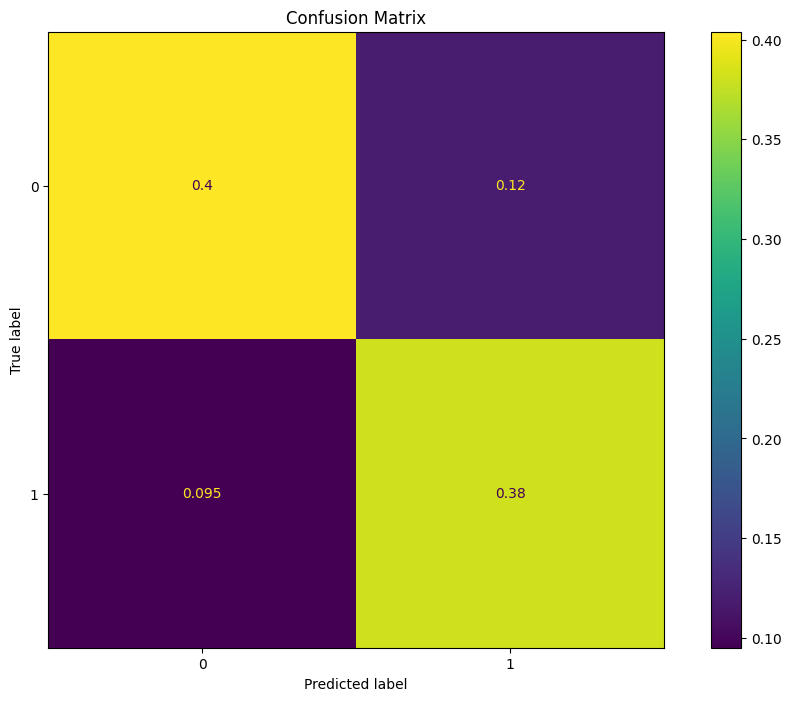

In [14]:
# Confusion matrix for the model
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix")
plt.show()

Look at features and importance

In [16]:
# DataFrame of the features and their importances
pd.DataFrame(
    {"feature": X.columns, "importance": rf.feature_importances_}
).sort_values(by="importance", ascending=False)

,feature,importance
27,bad,0.043504
487,worst,0.030634
174,great,0.021925
25,awful,0.014910
415,t,0.014668
...,...,...
18,aren t,0.000399
482,words,0.000393
491,writer,0.000385
351,room,0.000329
